In [1]:
"""
Summaries of USFS TreeMap linked to FIA plot data
Emphasis on 
    - Metrics of forest composition
    - Ecological gradients of species dominance
    - Forest structure (abundance, dominance, diversity, stand height)

Aggregate these statistics to FRP gridcells.

Author: maxwell.cook@colorado.edu
"""

import os, sys, time
import pandas as pd
import rioxarray as rxr
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgba

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# Load the TreeMap (ca. 2016)
# Pixel values here denote the FIA plot ID ("tm_id")
fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016.tif')
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto').squeeze()
# Grab some raster metadata
shp, gt, wkt, nd = treemap_da.shape, treemap_da.spatial_ref.GeoTransform, treemap_da.rio.crs, treemap_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {treemap_da[0].dtype}")
gc.collect() # clean up

Shape: (97383, 154221); 
GeoTransform: -2362845.0 30.0 0.0 3180555.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float64


54

In [3]:
# load and prepare our study region for cropping TreeMap
# Southern Rockies ecoregion bounds (buffered)
fp = os.path.join(projdir,'data/spatial/raw/boundaries/na_cec_eco_l3_srme.gpkg')
srm = gpd.read_file(fp)
# Crop the raster by the SRM bounds
bounds = srm.total_bounds # total bounds of ecoregion
treemap_da_c = treemap_da.rio.clip_box(
    minx=bounds[0]+10000, # +10km buffer
    miny=bounds[1]+10000, 
    maxx=bounds[2]+10000, 
    maxy=bounds[3]+10000
)
print(f"Cropped TreeMap to SRM bounds w/ 10km buffer.")
del treemap_da, bounds
gc.collect() # clean up

Cropped TreeMap to SRM bounds w/ 10km buffer.


54

In [4]:
# load the aggregated FRP grid
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
grid.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry'],
      dtype='object')

In [5]:
# get the count/proportion of unique "tm_id" from TreeMap in grids
t0 = time.time()

# see __functions.py
grid_tmid = compute_band_stats(grid, treemap_da_c, 'grid_index', attr='tm_id')

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

Total elapsed time: 0.51 minutes.

~~~~~~~~~~



In [6]:
# load the TreeMap Tree Table
fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016_tree_table.csv')
tree_tbl = pd.read_csv(fp)
print(tree_tbl.columns)

# tidy columns
grid_tmid['count'] = grid_tmid['count'].astype(int)
grid_tmid['total_pixels'] = grid_tmid['total_pixels'].astype(int)
grid_tmid.rename(columns={'total_pixels': 'forest_pixels'}, inplace=True)
print(grid_tmid.head(3))

# join to the grid data
grid_trees = grid_tmid.merge(tree_tbl, on='tm_id', how='left')

del tree_tbl # clean up this big table

print(f"\n{grid_trees.head(3)}")

Index(['tm_id', 'CN', 'STATUSCD', 'TPA_UNADJ', 'SPCD', 'COMMON_NAME',
       'SCIENTIFIC_NAME', 'SPECIES_SYMBOL', 'DIA', 'HT', 'ACTUALHT', 'CR',
       'SUBP', 'TREE', 'AGENTCD'],
      dtype='object')
   grid_index  tm_id  count  forest_pixels  pct_cover
0     1955419  12665      3            169   1.775148
1     1955419  20313      5            169   2.958580
2     1955419  45478      8            169   4.733728

   grid_index  tm_id  count  forest_pixels  pct_cover              CN  \
0     1955419  12665      3            169   1.775148  11746831010690   
1     1955419  12665      3            169   1.775148  11746831010690   
2     1955419  12665      3            169   1.775148  11746831010690   

   STATUSCD  TPA_UNADJ  SPCD     COMMON_NAME        SCIENTIFIC_NAME  \
0         1   6.018046   202     Douglas-fir  Pseudotsuga menziesii   
1         1   6.018046   122  ponderosa pine        Pinus ponderosa   
2         1   6.018046   202     Douglas-fir  Pseudotsuga menziesii   

  S

In [7]:
# Calculate the Shannon diversity index for each tm_id
# Total trees per tm_id
grid_trees['total_trees'] = grid_trees.groupby('tm_id')['TREE'].transform('sum')
grid_trees['p_species'] = grid_trees['TREE'] / grid_trees['total_trees'] # proportion

# Calculate Shannon diversity (H') for each tree row
grid_trees['Shannon_H'] = -grid_trees['p_species'] * np.log(grid_trees['p_species'])

# Aggregate to calculate H' at the tm_id level
shannon_tmid = (
    grid_trees.groupby('tm_id', as_index=False)
    .agg(shannon_h=('Shannon_H', 'sum'))
)

# merge back
grid_trees = grid_trees.merge(shannon_tmid, on='tm_id', how='left')

shannon_tmid.head(3)

,tm_id,shannon_h
0,3726,4.644333
1,3734,3.519616
2,3735,5.914445


In [8]:
# Calculate the Tree Table statistics across tm_id/grid_index combinations
#### Abundance (trees/acre, scaled to per-pixel)
#### Dominance (live basal area, scaled to per-pixel)
#### Tree height (average/species)

# force species name to lower case
grid_trees.rename(columns={'COMMON_NAME': 'species'}, inplace=True)
grid_trees['species'] = grid_trees['species'].str.lower()
grid_trees['live_dead'] = (grid_trees['STATUSCD'] == 1).astype(int)
# calculate the trees per acre, scaling by the acre/pixel factor
grid_trees['tree_tpa'] = (grid_trees['TREE'] * grid_trees['TPA_UNADJ']) * 0.222395 # trees/acre

# subset to live trees
grid_trees['BA'] = np.pi * (grid_trees['DIA'] / 2) ** 2  # Basal area in square feet
grid_trees['BA_TPAsc'] = grid_trees['BA'] * grid_trees['tree_tpa']  # adjust based on tree abundance

# group by grid_index and plot identifier (tm_id)
# calculate statistics for live/dead seperately
# merge into a single dataframe

# live trees
live_metrics = (
    grid_trees[grid_trees['live_dead'] == 1]
    .groupby(['grid_index', 'tm_id', 'species'], as_index=False)
    .agg(
        tmid_pixels=('count','max'), # retains the tm_id pixel count
        shannon_h=('shannon_h','max'), # retains the tm_id shannon index
        balive=('BA_TPAsc', 'sum'),    # Live basal area
        tpa_live=('tree_tpa', 'sum'),  # Total live tree count (trees/acre)
        tree_ht_live=('ACTUALHT','mean') # average tree height
    )
)

# dead trees
dead_metrics = (
    grid_trees[grid_trees['live_dead'] == 0]
    .groupby(['grid_index', 'tm_id', 'species'], as_index=False)
    .agg(
        badead=('BA_TPAsc', 'sum'),    # Live basal area
        tpa_dead=('tree_tpa', 'sum'),  # Total live tree count (trees/acre)
        tree_ht_dead=('ACTUALHT','mean') # average tree height
    )
)

# combine live/dead balive
tree_metrics = live_metrics.merge(
    dead_metrics, 
    on=['grid_index', 'tm_id', 'species'], 
    how='outer'
).fillna(0)
tree_metrics['tmid_acres'] =  tree_metrics['tmid_pixels'] * 0.222395 # total acres for the tm_id (pixels * conversion factor)
# subset to the tree metric columns
tree_metrics = tree_metrics[['grid_index','tm_id','tmid_pixels','tmid_acres','species','shannon_h',
                             'balive','badead','tpa_live','tpa_dead','tree_ht_live','tree_ht_dead']]
tree_metrics.head(12)

,grid_index,tm_id,tmid_pixels,tmid_acres,species,shannon_h,balive,badead,tpa_live,tpa_dead,tree_ht_live,tree_ht_dead
0,183297,5447,7.0,1.556765,common or two-needle pinyon,6.443664,2019.306716,1060.887083,36.136350,6.691917,16.111111,20.5
1,183297,5447,7.0,1.556765,utah juniper,6.443664,1206.746574,1910.490238,18.737367,13.383833,13.800000,12.0
2,183297,13033,45.0,10.007775,common or two-needle pinyon,6.118440,545.805142,211.136764,138.728761,4.015150,9.666667,10.0
3,183297,13033,45.0,10.007775,utah juniper,6.118440,2450.525649,0.000000,44.166650,0.000000,12.000000,0.0
4,183297,41520,11.0,2.446345,utah juniper,3.817086,975.721790,0.000000,6.691917,0.000000,12.500000,0.0
5,183297,41609,5.0,1.111975,utah juniper,5.774478,2595.425687,90.915159,138.844538,1.338383,10.307692,7.0
6,183297,46609,39.0,8.673405,common or two-needle pinyon,4.629669,165.568813,0.000000,5.353533,0.000000,15.000000,0.0
7,183297,46609,39.0,8.673405,oneseed juniper,4.629669,1882.298024,0.000000,5.353533,0.000000,14.666667,0.0
8,183297,69728,7.0,1.556765,common or two-needle pinyon,5.050953,136.399017,858.674699,4.015150,8.030300,10.500000,14.0
9,183297,69728,7.0,1.556765,utah juniper,5.050953,1266.137330,1079.051193,5.353533,6.691917,11.333333,10.0


In [12]:
# aggregate the TreeMap characteristics by FRP gridcell/species combinations
grid_tm = tree_metrics.groupby(['grid_index', 'species'], as_index=False).agg(
    tmid_unique=('tm_id', 'nunique'),
    tmid_acres=('tmid_acres','sum'),
    shannon_h=('shannon_h','mean'),
    balive=('balive', 'sum'),
    badead=('badead', 'sum'),   
    tpa_live=('tpa_live', 'sum'),  
    tpa_dead=('tpa_dead', 'sum') ,
    tree_ht_live=('tree_ht_live', 'mean'),
    tree_ht_dead=('tree_ht_dead', 'mean')
)

# Check results
grid_tm.head(10)

,grid_index,species,tmid_unique,tmid_acres,shannon_h,balive,badead,tpa_live,tpa_dead,tree_ht_live,tree_ht_dead
0,183297,common or two-needle pinyon,4,21.794710,5.560682,2867.079688,2130.698546,184.233794,18.737367,12.819444,11.125
1,183297,oneseed juniper,1,8.673405,4.629669,1882.298024,0.000000,5.353533,0.000000,14.666667,0.000
2,183297,utah juniper,5,16.679625,5.440924,8494.557030,3080.456590,213.794005,21.414133,11.988205,5.800
3,183298,common or two-needle pinyon,2,17.791600,4.840311,301.967830,858.674699,9.368683,8.030300,12.750000,7.000
4,183298,oneseed juniper,1,14.455675,4.629669,1882.298024,0.000000,5.353533,0.000000,14.666667,0.000
5,183298,utah juniper,2,3.558320,4.901853,12921.651968,1835.889142,119.116117,13.383833,10.734848,11.500
6,183299,common or two-needle pinyon,4,8.006220,4.968044,5408.851496,858.674699,455.610703,8.030300,12.687500,3.500
7,183299,fremont cottonwood,1,0.222395,8.399645,2414.804540,0.000000,130.814237,0.000000,42.111111,0.000
8,183299,honey mesquite,1,0.889580,4.412579,31.797705,0.000000,1.338383,0.000000,8.000000,0.000
9,183299,oneseed juniper,2,7.116640,4.918865,8060.996896,0.000000,45.505034,0.000000,12.483333,0.000


In [18]:
# join the FORTYPCD and FLDTYPCD summaries for grid indices
fp = os.path.join(projdir,'data/earth-engine/exports/treemap/gridstats_treemap_for_fld.csv')
fortypcd = pd.read_csv(fp)
print(fortypcd.columns)

# unpack the forest type histogram data ...
def parse_histogram(hist_str):
    # Convert float or NaN to string, then parse
    if isinstance(hist_str, float) or pd.isna(hist_str):
        hist_str = str(int(hist_str)) if not pd.isna(hist_str) else ""
    kv_pairs = hist_str.split(', ')  # Split the key-value pairs
    # Convert key-value pairs to a dictionary
    return {int(kv.split(':')[0]): float(kv.split(':')[1]) for kv in kv_pairs if ':' in kv}

# parse the dictionary
fortypcd['fortypcd_hist'] = fortypcd['fortypcd_hist'].apply(parse_histogram)

# merge the FORTYP and FLDTYP
fort = fortypcd['fortypcd_hist'].apply(pd.Series)
tmtyp = pd.concat([fortypcd.drop(columns=['fldtypcd_hist','fortypcd_hist']), fort], axis=1).reset_index(drop=True)
tmtyp.drop(columns=['.geo','system:index'], inplace=True)

print("Adjusted DataFrame:")
print(tmtyp.head(3))

# Pivot longer and join to get species name
tmtyp = tmtyp.melt(id_vars=['grid_index','total_pixels'], var_name='FORTYPCD', value_name='count')
tmtyp['FORTYPCD'] = tmtyp['FORTYPCD'].astype(int)

# Drop 'NaN' counts (species not present in the AFD)
tmtyp.dropna(subset=['count'], inplace=True)
tmtyp['count'] = tmtyp['count'].round().astype(int)
tmtyp['total_pixels'] = tmtyp['total_pixels'].astype(int)
tmtyp.sort_values(by=['grid_index'], inplace=True)
print("Dropped NA values.")
print(tmtyp.columns)

# load the species lookup table
fp = os.path.join(projdir,'data/tabular/mod/treemap_fortypcd_species_mapping.csv')
species_df = pd.read_csv(fp)
species_df = species_df[['FORTYPCD','SpeciesName']]
species_df = species_df[species_df['FORTYPCD'].isin(tmtyp['FORTYPCD'].unique())]
print(species_df.columns)

# merge with grid summary to get forest species name
tmtyp = tmtyp.merge(species_df, on='FORTYPCD', how='left')
print(f"\n{tmtyp.head(3)}")

# calculate the total forest count and percent cover for each species
forest_count = tmtyp.groupby('grid_index')['count'].sum().reset_index()
forest_count = forest_count.rename(columns={'count': 'forest_pix'})

# Join back to the data frame, calculate percent cover
# tidy the columns
tmtyp = tmtyp.merge(forest_count, on='grid_index', how='left')
tmtyp['fortypcd_pct'] = (tmtyp['count'] / tmtyp['forest_pix']) * 100
tmtyp['forest_pct'] = (tmtyp['forest_pix'] / tmtyp['total_pixels']) * 100
tmtyp.rename(columns={
    'FORTYPCD': 'fortypcd_code',
    'SpeciesName': 'fortypcd_name',
    'count': 'fortypcd_ct'
}, inplace=True)
     
# subset the columns
cols = ['grid_index', 'fortypcd_code', 'fortypcd_name', 'fortypcd_ct', 'fortypcd_pct', 'forest_pix', 'forest_pct']
tmtyp = tmtyp[cols]

# check the results
tmtyp = tmtyp.sort_values(by=['grid_index'])

# join to the tree table grid
grid_tm_fortyp = grid_tm.merge(tmtyp, on='grid_index', how='left')

# del fortypcd, fort, tmtyp, species_df
# gc.collect()

Index(['system:index', 'fldtypcd_hist', 'fortypcd_hist', 'grid_index',
       'total_pixels', '.geo'],
      dtype='object')
Adjusted DataFrame:
   grid_index  total_pixels       182  185        201         221        261  \
0     1690163    195.015686  3.000000  3.0  16.145098  118.152941  31.098039   
1     1690164    194.752941  3.000000  NaN   9.262745  166.690196  15.513725   
2     1692414    194.988235  1.180392  4.0  24.427451  120.721569  30.956863   

        265  266       267  ...  402  972  935  809  367  171  923  263  805  \
0  3.360784  2.0  6.768627  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1       NaN  NaN  0.227451  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  3.317647  NaN  1.000000  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   924  
0  NaN  
1  NaN  
2  NaN  

[3 rows x 59 columns]
Dropped NA values.
Index(['grid_index', 'total_pixels', 'FORTYPCD', 'count'], dtype='object')
Index(['FORTYPCD', 'SpeciesName'], dtype='object')

   grid_

In [19]:
grid_tm_fortyp.head(10)

,grid_index,species,tmid_unique,tmid_acres,shannon_h,balive,badead,tpa_live,tpa_dead,tree_ht_live,tree_ht_dead,fortypcd_code,fortypcd_name,fortypcd_ct,fortypcd_pct,forest_pix,forest_pct
0,183297,common or two-needle pinyon,4,21.794710,5.560682,2867.079688,2130.698546,184.233794,18.737367,12.819444,11.125,185.0,Pinyon / juniper woodland,113.0,84.328358,134.0,67.336683
1,183297,common or two-needle pinyon,4,21.794710,5.560682,2867.079688,2130.698546,184.233794,18.737367,12.819444,11.125,184.0,Juniper woodland,21.0,15.671642,134.0,67.336683
2,183297,oneseed juniper,1,8.673405,4.629669,1882.298024,0.000000,5.353533,0.000000,14.666667,0.000,185.0,Pinyon / juniper woodland,113.0,84.328358,134.0,67.336683
3,183297,oneseed juniper,1,8.673405,4.629669,1882.298024,0.000000,5.353533,0.000000,14.666667,0.000,184.0,Juniper woodland,21.0,15.671642,134.0,67.336683
4,183297,utah juniper,5,16.679625,5.440924,8494.557030,3080.456590,213.794005,21.414133,11.988205,5.800,185.0,Pinyon / juniper woodland,113.0,84.328358,134.0,67.336683
5,183297,utah juniper,5,16.679625,5.440924,8494.557030,3080.456590,213.794005,21.414133,11.988205,5.800,184.0,Juniper woodland,21.0,15.671642,134.0,67.336683
6,183298,common or two-needle pinyon,2,17.791600,4.840311,301.967830,858.674699,9.368683,8.030300,12.750000,7.000,185.0,Pinyon / juniper woodland,92.0,98.924731,93.0,46.733668
7,183298,common or two-needle pinyon,2,17.791600,4.840311,301.967830,858.674699,9.368683,8.030300,12.750000,7.000,184.0,Juniper woodland,1.0,1.075269,93.0,46.733668
8,183298,oneseed juniper,1,14.455675,4.629669,1882.298024,0.000000,5.353533,0.000000,14.666667,0.000,185.0,Pinyon / juniper woodland,92.0,98.924731,93.0,46.733668
9,183298,oneseed juniper,1,14.455675,4.629669,1882.298024,0.000000,5.353533,0.000000,14.666667,0.000,184.0,Juniper woodland,1.0,1.075269,93.0,46.733668


In [21]:
print(len(grid_tmid))
print(f"\n{len(tmtyp)}")
print(f"\n{len(grid_tm_fortyp)}\n")

1394621

351748

4723686





Species making up 97% of the total *metric*: 

                        species        balive      tpa_live  balive_f  \
89               ponderosa pine  7.841141e+10  1.473605e+09  0.361834   
65               lodgepole pine  4.335673e+10  2.979155e+09  0.200072   
51                    grand fir  2.255418e+10  5.737182e+08  0.104078   
41                  douglas-fir  1.722655e+10  4.651291e+08  0.079493   
129                   white fir  8.878827e+09  2.967258e+08  0.040972   
61                 jeffrey pine  8.444925e+09  1.268273e+08  0.038970   
107               subalpine fir  8.229059e+09  6.332309e+08  0.037974   
48             engelmann spruce  6.639218e+09  3.110734e+08  0.030637   
123             western juniper  4.612896e+09  9.413978e+07  0.021286   
90                quaking aspen  4.035885e+09  2.471425e+08  0.018624   
124               western larch  3.018063e+09  1.045870e+08  0.013927   
59                incense-cedar  2.513569e+09  4.266878e+07  0.011599   
39

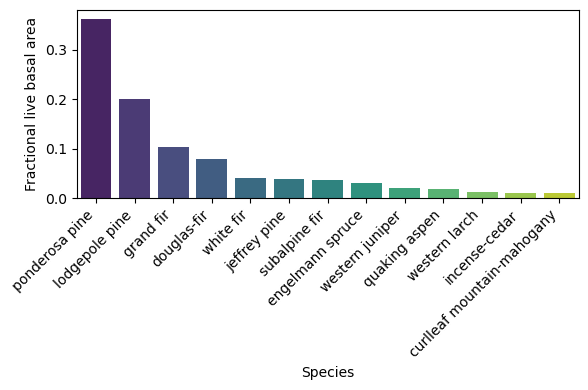

In [15]:
# calculate the landscape fraction (prevalence)
spp_pr = (
    grid_tm.groupby('species', as_index=False)
    .agg(
        balive=('balive','sum'),
        tpa_live=('tpa_live', 'sum')
    )
)
# calculate the fraction
spp_pr['balive_f'] = spp_pr['balive'] / spp_pr['balive'].sum()
spp_pr['tpa_f'] = spp_pr['tpa_live'] / spp_pr['tpa_live'].sum()

# sort values and plot
spp_pr = spp_pr.sort_values(by='balive_f', ascending=False)

# which species make up 97% of observations?
spp_pr['balive_f_csum'] = spp_pr['balive_f'].cumsum()
spp_pr['tpa_f_csum'] = spp_pr['tpa_f'].cumsum()
top_species = spp_pr[spp_pr['balive_f_csum'] <= 0.97]
print(f"\n\nSpecies making up 97% of the total *metric*: \n\n{top_species}\n\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='species', y='balive_f', palette='viridis')
plt.xlabel('Species')
plt.ylabel('Fractional live basal area')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
spp_dom = (
    grid_trees.groupby(['grid_index', 'COMMON_NAME'])
    .size()
    .reset_index(name='frequency')  # Count occurrences of each species
    .sort_values(['grid_index', 'frequency'], ascending=[True, False])
    .drop_duplicates('grid_index')  # Keep only the top species per grid_index
)
print(spp_dom.head())

# calculate the landscape fraction (prevalence)
spp_dom = spp_dom.groupby('COMMON_NAME')['frequency'].sum().reset_index()
spp_dom['fraction'] = spp_dom['frequency'] / spp_dom['frequency'].sum()
spp_dom = spp_dom.sort_values(by='fraction', ascending=False)

# which species make up 97% of observations?
spp_dom['c_fraction'] = spp_dom['fraction'].cumsum()
top_species = spp_dom[spp_dom['c_fraction'] <= 0.97]
print(f"\n\nSpecies making up 97% of the total: \n\n{top_species}\n\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='COMMON_NAME', y='fraction', palette='viridis')
plt.xlabel('Species')
plt.ylabel('Fractional (frequency)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Prepare data for stacked bar plot
stacked_data = comparison_table.set_index('COMMON_NAME')[
    ['fraction_balive', 'fraction_abundance', 'weighted_frequency']
].T

# Plot the stacked bar chart
stacked_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='viridis'
)

# Customize the plot
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.title('Species Contribution by Different Metrics', fontsize=14)
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# do some species regrouping and renaming
spp_grouping = {
    'pinyon|juniper': 'pinon-juniper',
    ' fir|spruce': 'spruce-fir',
    'ponderosa pine': 'ponderosa',
    'lodgepole pine': 'lodgepole'
}

spp_remap = {}
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = grid_trees[grid_trees['COMMON_NAME'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update({name: spp_group for name in spp['COMMON_NAME'].unique()})

# Apply the remap to create a new grouped species column
grid_trees['SpeciesGroup'] = grid_trees['COMMON_NAME'].map(spp_remap).fillna(grid_trees['COMMON_NAME'])

# Verify the updated species groups
print(grid_trees[['COMMON_NAME', 'SpeciesGroup']].drop_duplicates().head(10))

In [ ]:
# merge the live basal area
grid_trees = grid_trees.merge(ba_by_species, on=['grid_index', 'tm_id', 'COMMON_NAME'], how='left')
grid_trees[['grid_index','tm_id','count','COMMON_NAME','balive']].head(10)

In [ ]:
# Collapse the tree data to species
row_counts = (
    grid_trees.groupby(['grid_index', 'tm_id', 'COMMON_NAME'])
    .size()
    .reset_index(name='tree_count')  # Name the count column 'tree_count'
)
# Merge the tree_count back into the original grid_trees DataFrame
grid_trees_sp = grid_trees.merge(row_counts, on=['grid_index', 'tm_id', 'COMMON_NAME'], how='left')
grid_trees_sp = grid_trees_sp.drop_duplicates(subset=['grid_index', 'tm_id', 'COMMON_NAME'])
grid_trees_sp[['grid_index', 'tm_id', 'COMMON_NAME', 'SpeciesGroup', 'tree_count', 'balive']].head(10)

In [ ]:
# identify the dominant forest species for each "tm_id"
spp_dominance = (
    grid_trees_sp.groupby(['tm_id', 'SpeciesGroup'])['balive']  # Sum tree counts (or use another metric)
    .sum()
    .reset_index()
    .sort_values(['tm_id', 'balive'], ascending=[True, False])
    .drop_duplicates('tm_id')  # Keep only the top species per tm_id
)

# join back to the tm_id summary
grid_tmid_spp = grid_tmid.merge(spp_dominance[['tm_id', 'SpeciesGroup']], on='tm_id', how='left')

# identify the landscape proportion of dominant species
spp_pr = (
    grid_tmid_spp.groupby('SpeciesGroup')['count']
    .sum()
    .reset_index()
    .rename(columns={'count': 'maj_spp_count'})
    .sort_values(by='maj_spp_count', ascending=False)
)

# calculate the fraction
spp_pr['fraction'] = spp_pr['maj_spp_count'] / spp_pr['maj_spp_count'].sum()
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)

# Identify species contributing 97% of the burned area
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['c_fraction'] <= 0.97]
print(f"\nSpecies contributing to 97% of the burned area:\n{top_species}\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='SpeciesGroup', y='fraction', palette='viridis')
plt.xlabel('Species')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the species gradient (proportions) based on Tree Table
grid_trees.columns

In [ ]:
# Calculate abundance (count) and dominance (basal area) for each species in each tm_id
sp_abundance = (
    grid_trees.groupby(['tm_id', 'COMMON_NAME'])['TREE'] 
    .sum()
    .reset_index()
    .rename(columns={'TREE': 'abundance'})
)
sp_dominance = (
    grid_trees.groupby(['tm_id', 'COMMON_NAME'])['balive']
    .sum()
    .reset_index()
    .rename(columns={'balive': 'dominance'})
)

# join these together
composition = sp_abundance.merge(sp_dominance, on=['tm_id', 'COMMON_NAME'], how='outer').fillna(0)

# Normalize abundance/dominance within each tm_id (plot)
composition['abundance'] = (
    composition.groupby('tm_id')['abundance'].transform(lambda x: x / x.sum())
)
composition['dominance'] = (
    composition.groupby('tm_id')['dominance'].transform(lambda x: x / x.sum())
)

# check the results
composition.head()

In [ ]:
ba_by_species[ba_by_species['tm_id'] == 3726]

In [ ]:
composition[composition['tm_id'] == 3726]

In [ ]:
grid_trees[grid_trees['tm_id'] == 3726]

In [ ]:
# test tree table
tree_tbl[tree_tbl['tm_id'] == 21404][['tm_id','COMMON_NAME','DIA','HT','CR','TREE']]